# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


plt.style.use('seaborn')


# Read in and combine all relevant data

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df['quarter'] = pd.PeriodIndex(df.date, freq='Q')

df3 = pd.read_csv('data/WASTHPI.csv')
df3['quarter'] = pd.PeriodIndex(df3.DATE, freq='Q')

df_master = df.merge(df3, on = 'quarter' )

df_master['year'] = pd.PeriodIndex(df_master.date, freq='Y')
df_master_no_object = df_master.drop(['year', 'quarter','date'], axis = 1)

df4 = pd.read_csv('data/ACSST5Y2015.S1903-Data.csv')
df4 = df4[['NAME','S1903_C02_001E']]

df4['NAME'] = df4.NAME.str.split(' ').str[1]
df4 = df4.drop([0, 599])
df4['year'] = '2015'
df4=df4.rename(columns={"NAME": "zipcode"})

df_master.zipcode = df_master.zipcode.astype(str)
df_master.year = df_master.year.astype(str)

df_income_2015 = df_master.merge(df4, on = ['zipcode','year'])

df5 = pd.read_csv('data/ACSST5Y2014.S1903-Data.csv')
df5 = df5[['NAME','S1903_C02_001E']]
df5['NAME'] = df5.NAME.str.split(' ').str[1]
df5 = df5.drop([0, 599])
df5['year'] = '2014'
df5=df5.rename(columns={"NAME": "zipcode"})

df_income_2014 = df_master.merge(df5, on = ['zipcode','year'])

df_income = pd.concat([df_income_2014,df_income_2015], axis = 0)
df_income.S1903_C02_001E = df_income.S1903_C02_001E.astype(int)
df_income = df_income.reset_index().drop('index', axis=1)
df_income.quarter = df_income.quarter.astype(str)

df_income_merge = df_income[['id','date','quarter','WASTHPI_CHG','year','S1903_C02_001E']]

df_full_set = df.merge(df_income_merge, on = ['id','date'])
df_full_set = df_full_set.rename(columns = {'WASTHPI_CHG' : 'HPI', 'S1903_C02_001E': 'Median_Income'})

df_full_set

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,quarter_x,quarter_y,HPI,year,Median_Income
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,98178,47.5112,-122.257,1340,5650,2014Q4,2014Q4,4.34,2014,59637
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,98125,47.7210,-122.319,1690,7639,2014Q4,2014Q4,4.34,2014,52353
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,98028,47.7379,-122.233,2720,8062,2015Q1,2015Q1,5.95,2015,90588
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,98136,47.5208,-122.393,1360,5000,2014Q4,2014Q4,4.34,2014,85040
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,98074,47.6168,-122.045,1800,7503,2015Q1,2015Q1,5.95,2015,145262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,98103,47.6993,-122.346,1530,1509,2014Q2,2014Q2,10.94,2014,76925
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,98146,47.5107,-122.362,1830,7200,2015Q1,2015Q1,5.95,2015,58429
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,98144,47.5944,-122.299,1020,2007,2014Q2,2014Q2,10.94,2014,60143
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,98027,47.5345,-122.069,1410,1287,2015Q1,2015Q1,5.95,2015,102025


# Train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split( df_full_set.drop(columns = 'price' , axis = 1) , df_full_set['price'] , test_size=0.2, random_state = 42)

training_data = pd.concat([X_train, y_train], axis = 1)
test_data = pd.concat([X_test, y_test], axis = 1)

# Check correlations between all features

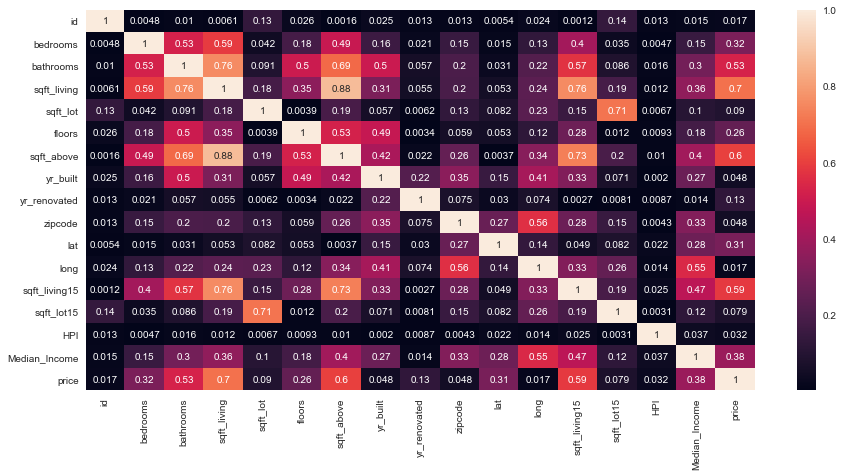

In [4]:
fig, ax = plt.subplots(figsize = (15,7))
sns.heatmap(training_data.corr().abs(), annot = True, ax = ax);

# Find highest collinearity

In [18]:
pairs_df = training_data.drop(columns = 'price', axis = 1).corr().abs().stack().reset_index().sort_values(0, ascending = False)
pairs_df['Pairs'] = list(zip(pairs_df.level_0, pairs_df.level_1))
pairs_df.set_index(['Pairs'], inplace = True)
pairs_df.drop(columns = ['level_0', 'level_1'], inplace = True)
pairs_df.columns = ['CC']
pairs_df.drop_duplicates(inplace = True)
pairs_df[(pairs_df.CC > 0.6) & (pairs_df.CC < 1)]

,CC
Pairs,
"(sqft_above, sqft_living)",0.875670
"(sqft_living, sqft_living15)",0.759525
"(bathrooms, sqft_living)",0.758467
"(sqft_above, sqft_living15)",0.734664
"(sqft_lot, sqft_lot15)",0.709840
"(sqft_above, bathrooms)",0.687644


# Scatter Matrix

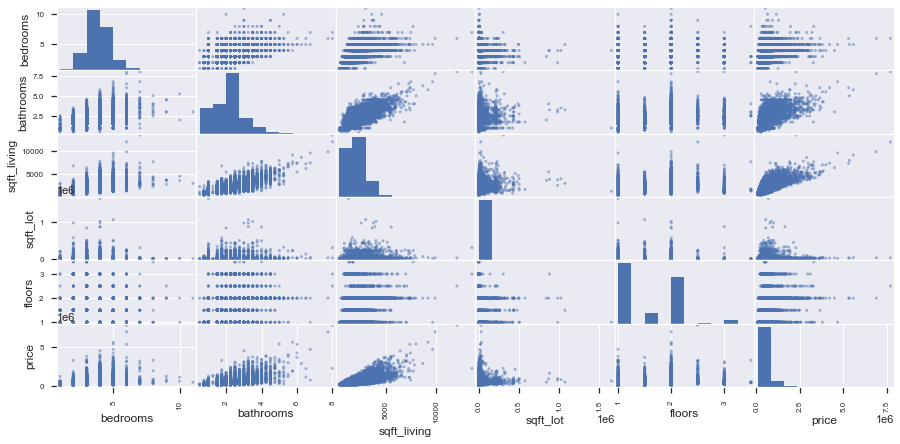

In [19]:
pd.plotting.scatter_matrix(training_data[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','price']], figsize = (15,7));

# Create property map

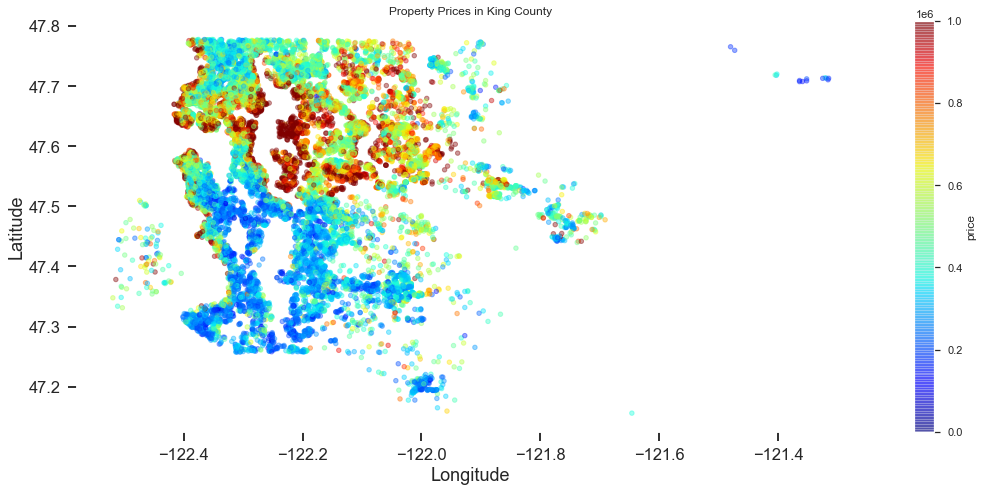

In [11]:
fig,ax = plt.subplots()
plt.style.use('seaborn')
sns.set_context('notebook')
training_data.plot(kind = 'scatter',x = 'long', y = 'lat', alpha = 0.4 , c = 'price', cmap=plt.get_cmap('jet'), colorbar = True, vmin = 0, vmax = 1e6, figsize = (15,7),ax=ax);
ax.grid(False)
ax.set_facecolor('White')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Property Prices in King County');
plt.tight_layout()

# Explore log scaling

<AxesSubplot:>

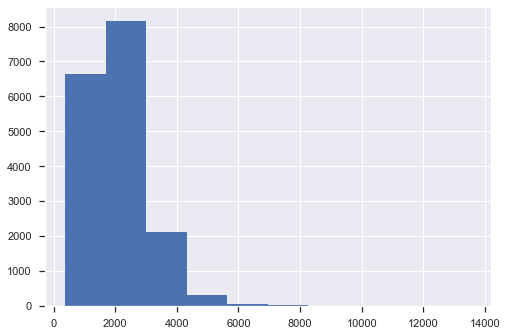

In [12]:
training_data['sqft_living'].hist()

<AxesSubplot:>

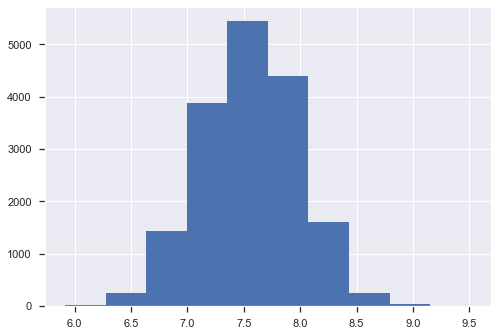

In [13]:
np.log(training_data['sqft_living']).hist()

<AxesSubplot:>

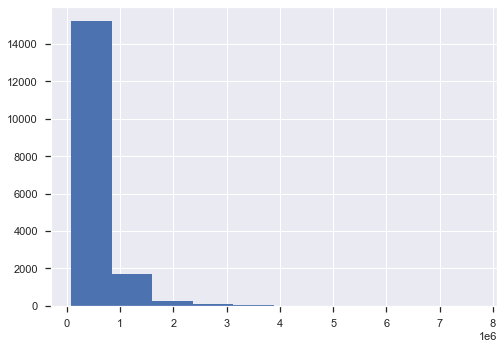

In [14]:
training_data['price'].hist()

<AxesSubplot:>

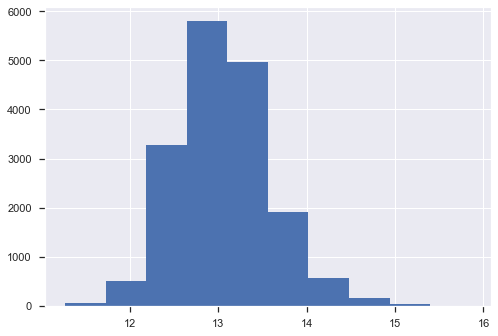

In [15]:
np.log(training_data['price']).hist()

# Feature Engineering and new heatmap

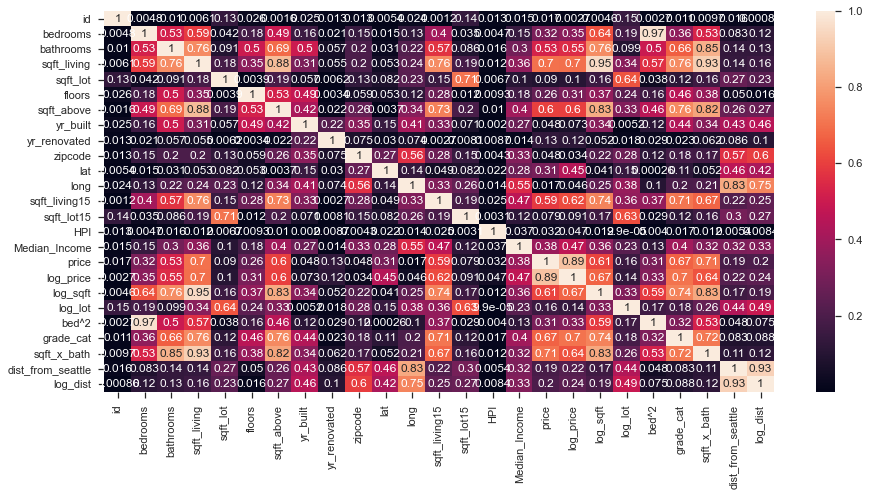

In [16]:
feature_testing = training_data.copy()

fig,ax = plt.subplots(figsize = (15,7))

def custom_transformations(df):
    df['grade_cat'] = df['grade'].str.split().str[0].astype(int)
    df['dist_from_seattle'] = np.sqrt( (df['lat'] - 47.6050) ** 2 + (df['long'] + 122.3344) ** 2)
    df['log_sqft'] = np.log(df['sqft_living'])
    df['log_dist'] = np.log(df['dist_from_seattle'])

    
feature_testing['log_price'] = np.log(feature_testing['price'])
feature_testing['log_sqft'] = np.log(feature_testing['sqft_living'])
feature_testing['log_lot'] = np.log(feature_testing['sqft_lot'])


feature_testing['bed^2'] = feature_testing['bedrooms'] ** 2
feature_testing['grade_cat'] = feature_testing['grade'].str.split().str[0].astype(int)


feature_testing['sqft_x_bath'] = feature_testing['sqft_living'] * feature_testing['bathrooms']

feature_testing['dist_from_seattle'] = np.sqrt( (feature_testing['lat'] - 47.6050) ** 2 + (feature_testing['long'] + 122.3344) ** 2)
feature_testing['log_dist'] = np.log(feature_testing['dist_from_seattle'])

ax = sns.heatmap(feature_testing.corr().abs(), annot = True, ax = ax);




# Dummy Regressor

In [20]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

dummy_regr = DummyRegressor(strategy="mean")

X = training_data['bathrooms'].values.reshape(-1,1)
y = y_train

dummy_regr.fit(X, y)
print(dummy_regr.score(X, y))

predicted_y = dummy_regr.predict(X)

rmse = np.sqrt(mean_squared_error(predicted_y,y))
print(rmse)

0.0
368958.0485742971


# Square Feet only baseline

R^2:  0.49249290659878187
Adjusted R^2 : 0.49246352847470654
Median Absolute Error: 130018.59036998049
RMSE:  262843.98745441716
Median Percentage Error: 28.504870483935658
[282.20150555]


Text(0.5, 1.0, 'Predicted vs Actual Price for Training Data')

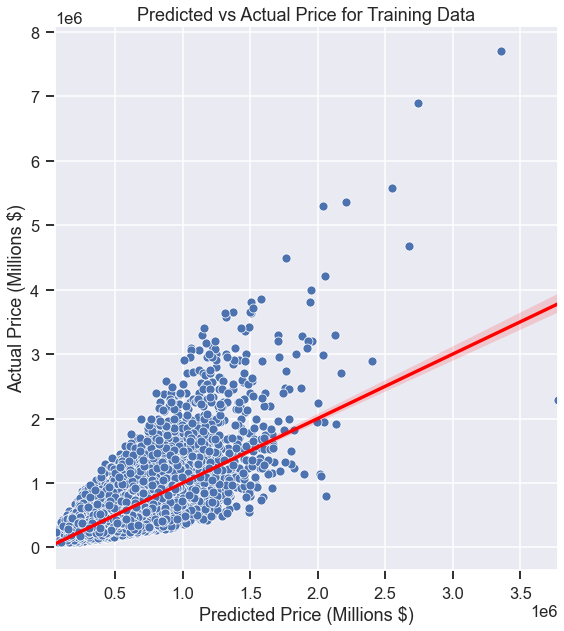

In [23]:
X = feature_testing[['sqft_living']]#,'bathrooms','yr_built','bedrooms','sqft_lot','floors','sqft_above','sqft_living15','sqft_lot15']]
y = y_train

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#poly = PolynomialFeatures(3)
#X = poly.fit_transform(X)

lr = LinearRegression()
lr.fit(X, y)

print('R^2: ',lr.score(X,y))
print('Adjusted R^2 :', 1 - ( 1-lr.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))
predicted_y = lr.predict(X)

med_ae = median_absolute_error(y,predicted_y)
print('Median Absolute Error:',med_ae)

rmse = np.sqrt(mean_squared_error(predicted_y,y))
print('RMSE: ',rmse)
#print("Median Error: ", np.median(np.abs(predicted_y - y)))
print('Median Percentage Error:', np.median(np.abs(predicted_y - y) / y)*100)
#print(np.linalg.cond(X))
print(lr.coef_)

#fig, axs = plt.subplots(3, figsize = (15,15));
#axs[0].scatter(predicted_y, y, alpha = 0.4)
#axs[1].scatter(predicted_y, predicted_y - y, alpha = 0.4);
#ax.hlines(xmin = min(predicted_y), xmax = max(predicted_y), y = 0, color = 'r')

sns.set_context('talk')
fig,ax = plt.subplots(figsize = (9,10))
ax = sns.scatterplot(x = predicted_y, y=y)
ax = sns.regplot(x = predicted_y,y = y,scatter = False, color = 'red')
ax.set_xlabel('Predicted Price (Millions $)')
ax.set_ylabel('Actual Price (Millions $)')
ax.set_title('Predicted vs Actual Price for Training Data')

# Analysis for best polynomial fit

In [26]:
X = feature_testing[['log_sqft','bathrooms','log_dist','yr_built','grade_cat','Median_Income','HPI','bedrooms','floors','sqft_lot','sqft_lot15']]
y = np.log(training_data['price'])

x_train, x_val, y_train, y_val = train_test_split(X,y, train_size=0.75)

In [27]:
# To iterate over the range, select the maximum degree of the polynomial
maxdeg = 6

# Create two empty lists to store training and validation MSEs
training_error, validation_error = [],[]

# Loop through the degrees of the polynomial to create different models
for d in range(1,maxdeg):
    
    # Compute the polynomial features for the current degree 
    # for the train set
    x_poly_train = PolynomialFeatures(d).fit_transform(x_train)

    # Compute the polynomial features for the validation set
    x_poly_val = PolynomialFeatures(degree = d).fit_transform(x_val)
    
    # Initialize a linear regression model
    lreg = LinearRegression(fit_intercept=True)

    # Fit the model on the train data
    lreg.fit(x_poly_train, y_train)
    
    # Use the trained model to predict on the transformed train data
    y_train_pred = lreg.predict(x_poly_train)

    # Use the trained model to predict on the transformed validation data
    y_val_pred = lreg.predict(x_poly_val)
    
    # Compute the MSE on the train predictions
    #training_error.append(np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred))))

    # Compute the MSE on the validation predictions
    #validation_error.append(np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred))))
    
    training_error.append(np.median(np.abs(np.exp(y_train_pred) - np.exp(y_train)) / np.exp(y_train))*100)
    validation_error.append(np.median(np.abs(np.exp(y_val_pred) - np.exp(y_val)) / np.exp(y_val))*100)

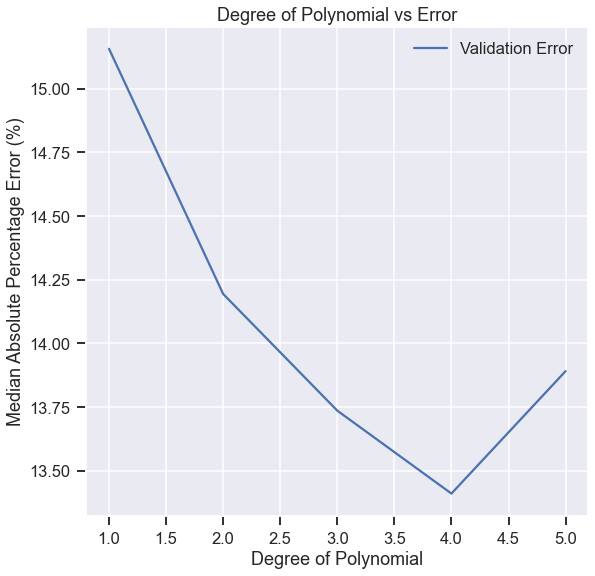

In [28]:
# Plot the errors as a function of increasing d value to visualise the training 
# and testing errors
fig, ax = plt.subplots(figsize = (9,9))

# Plot the training error with labels
#ax.plot(np.arange(1, maxdeg), training_error, label="Training Error")

# Plot the validation error with labels
ax.plot(np.arange(1, maxdeg), validation_error, label="Validation Error")

# Set the plot labels and legends
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Median Absolute Percentage Error (%)')
ax.legend(loc = 'best')
ax.set_title('Degree of Polynomial vs Error')
#ax.set_yscale('log')
plt.show();

# Standard Scaling and Polynomial Regression

R^2:  0.8304940733189959
Adjusted R^2 : 0.8284082743852674
Median Absolute Error: 61437.321593762084
RMSE:  151904.07779860907
Median Percentage Error: 13.521207863716725


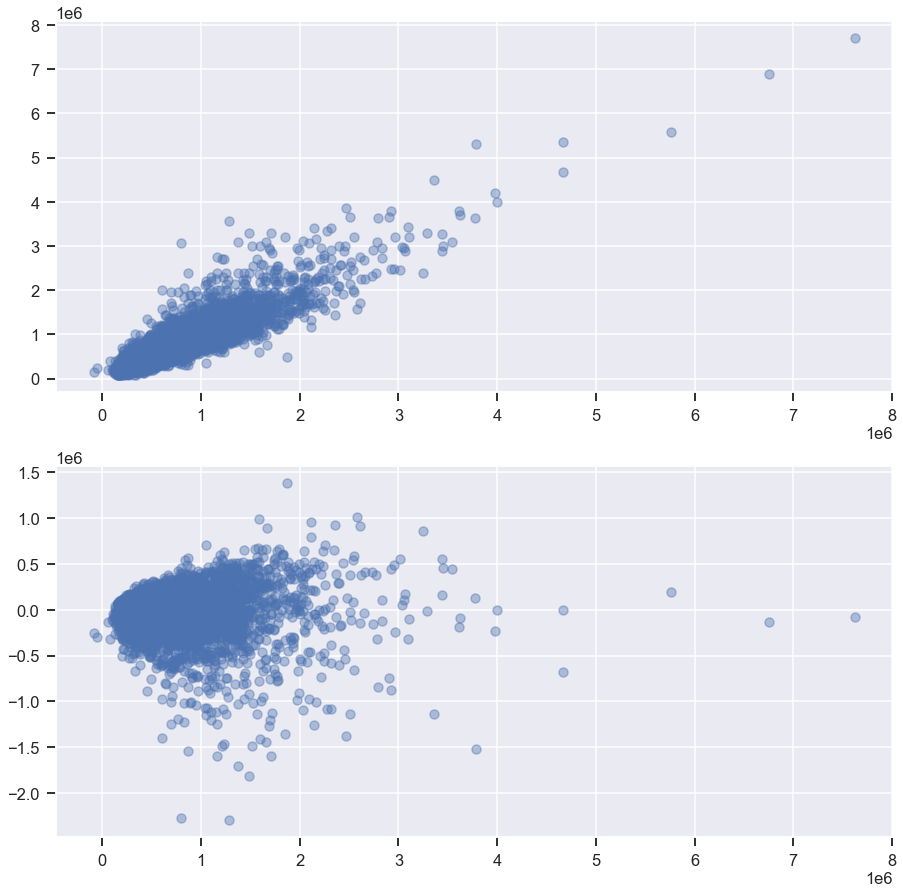

In [24]:
X = feature_testing[['sqft_living','bathrooms','dist_from_seattle','yr_built','grade_cat','Median_Income']]
y = y_train

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(4)
X = poly.fit_transform(X)

lr = LinearRegression()
lr.fit(X, y)

print('R^2: ',lr.score(X,y))
print('Adjusted R^2 :', 1 - ( 1-lr.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))
predicted_y = lr.predict(X)

med_ae = median_absolute_error(y,predicted_y)
print('Median Absolute Error:',med_ae)

rmse = np.sqrt(mean_squared_error(predicted_y,y))
print('RMSE: ',rmse)
#print("Median Error: ", np.median(np.abs(predicted_y - y)))
print('Median Percentage Error:', np.median(np.abs(predicted_y - y) / y)*100)
#print(np.linalg.cond(X))

fig, axs = plt.subplots(2, figsize = (15,15));

axs[0].scatter(predicted_y, y, alpha = 0.4)
axs[1].scatter(predicted_y, predicted_y - y, alpha = 0.4);
#ax.hlines(xmin = min(predicted_y), xmax = max(predicted_y), y = 0, color = 'r')
#ax.plot(np.linspace(0,6e6, 17277), predicted_y)

# Add final features

R^2:  0.8515688785214772
Adjusted R^2 : 0.838835016362079
MSE ss: 0.04133201261861749
Median Absolute Error: 52445.04693587427
RMSE:  135417.080837355
Condition Number:  3228591.683794828
Median Percentage Error: 11.67142790863086


(0.0, 7400000.0)

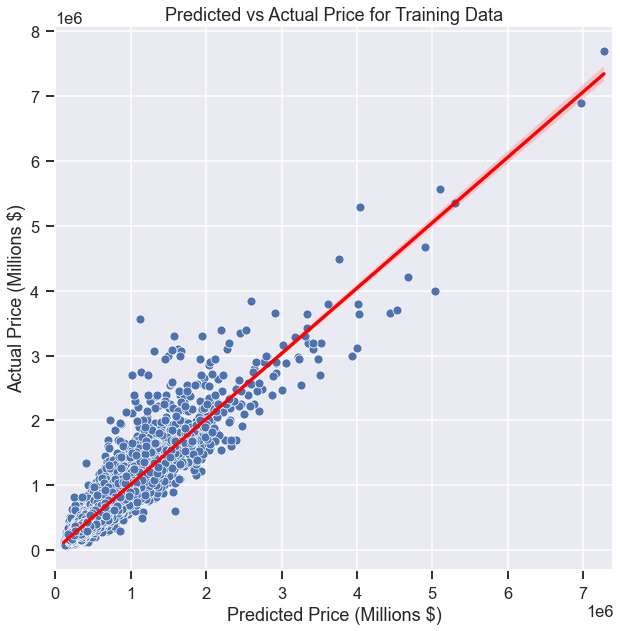

In [25]:
X = feature_testing[['log_sqft','bathrooms','log_dist','yr_built','grade_cat','Median_Income','HPI','bedrooms','sqft_lot15','sqft_lot','floors']]

y = pd.Series(np.log(feature_testing['price']))

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(4)
X = poly.fit_transform(X)

lr = LinearRegression()
lr.fit(X, y)

print('R^2: ',lr.score(X,y))
print('Adjusted R^2 :', 1 - ( 1-lr.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 ))

predicted_y = lr.predict(X)

rmse = np.sqrt(mean_squared_error(np.exp(y),np.exp(predicted_y)))

med_ae = median_absolute_error(np.exp(y),np.exp(predicted_y))
print('MSE ss:' ,mean_squared_error(y,predicted_y))
print('Median Absolute Error:',med_ae)
print('RMSE: ',rmse)
#print("Median Error: ", np.median(np.exp(predicted_y) - np.exp(y)))

print('Condition Number: ',np.linalg.cond(X))

#fig, axs = plt.subplots(2, figsize = (15,12));
#axs[0].scatter(predicted_y, y, alpha = 0.4)
#axs[0].scatter(np.exp(predicted_y), np.exp(y), alpha = 0.4)
#axs[1].scatter(np.exp(predicted_y), np.exp(predicted_y) - np.exp(y), alpha = 0.4);

#axs[1].scatter(predicted_y, predicted_y - y, alpha = 0.4);
#sns.heatmap(pd.concat([y, X], axis = 1).corr().abs(), annot = True, ax = axs[2]);
#ax.hlines(xmin = min(predicted_y), xmax = max(predicted_y), y = 0, color = 'r')
#ax.plot(np.linspace(0,6e6, 17277), predicted_y)

print('Median Percentage Error:', np.median(np.abs(np.exp(predicted_y) - np.exp(y)) / np.exp(y))*100)

fig,ax = plt.subplots(figsize = (10,10))
ax = sns.scatterplot(x = np.exp(predicted_y), y=np.exp(y))
ax = sns.regplot(x = np.exp(predicted_y),y = np.exp(y),scatter = False, color = 'red')
ax.set_xlabel('Predicted Price (Millions $)')
ax.set_ylabel('Actual Price (Millions $)')
ax.set_title('Predicted vs Actual Price for Training Data')
ax.set_xlim(0,7.4e6)
#print(predicted_y - y)

# Cross Validation (Slight overfitting? To address in the future)

In [36]:
scores = cross_val_score(lr, X, y, scoring = 'explained_variance', cv = 10)
lr_scores = scores

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard Deviation:', scores.std())
    
display_scores(lr_scores)

Scores: [0.78783478 0.78966762 0.79159107 0.77893182 0.78550893 0.78578948
 0.77789175 0.78204922 0.77785595 0.77227976]
Mean: 0.7829400387458803
Standard Deviation: 0.005836194961796941


# Test on unseen data

In [37]:
custom_transformations(test_data)

Median Absolute Percentage Error: 12.628231500880332


Text(0.5, 1.0, 'Predicted vs Actual Price for Train & Test Data')

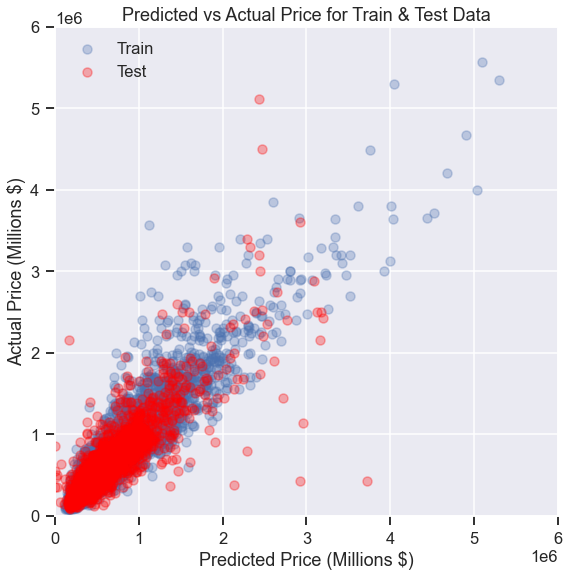

In [39]:
X_test_data = test_data[['log_sqft','bathrooms','log_dist','yr_built','grade_cat','Median_Income','HPI','bedrooms','sqft_lot15','sqft_lot','floors']]
y_test_data = np.log(y_test)


X_test_data = scaler.transform(X_test_data)
X_test_data = poly.transform(X_test_data)

test_predictions = lr.predict(X_test_data)
#print('Adjusted R^2 :', 1 - ( 1-lr.score(X_test_data, (y_test_data) ) * ( len(y_test_data) - 1 ) / ( len(y_test_data) - X_test_data.shape[1] - 1 )))
#rmse = np.sqrt(mean_squared_error(test_predictions,y_test_data))
#print('RMSE: ',rmse)
#print("Median Error: ", np.median(test_predictions - y_test_data))
#print('Mean Percentage Error (No log):', np.mean(np.abs(predicted_y - y) / y)*100)
print('Median Absolute Percentage Error:', np.median(np.abs(np.exp(test_predictions) - np.exp(y_test_data)) / np.exp(y_test_data))*100)


#med_ae = median_absolute_error(np.exp(y_test_data),np.exp(test_predictions))
#print('Median Absolute Error:',med_ae)
fig,ax = plt.subplots(figsize = (9,9))
ax.scatter(np.exp(predicted_y), np.exp(y), alpha = 0.3, label = 'Train')
ax.scatter(np.exp(test_predictions), np.exp(y_test_data), color = 'r', alpha = 0.3,label = 'Test')
ax.set_xlim((0,0.6e7))
ax.set_ylim((0,0.6e7))
ax.legend(loc = 'upper left')
ax.set_xlabel('Predicted Price (Millions $)')
ax.set_ylabel('Actual Price (Millions $)')
ax.set_title('Predicted vs Actual Price for Train & Test Data')

#print()
#print()
#print(np.exp(y_test_data).head(15))
#print(np.exp(test_predictions)[:15])
#print((np.exp(y_test_data) - np.exp(test_predictions)).head(20))
#print(y_test[17601])
#print(np.exp(test_predictions[17601]))